# Gathering seeing data

I had some discussions with [Miguel Rodríguez Alarcon (IAC)](https://scholar.google.com/citations?user=ySJtt44AAAAJ&hl=es&oi=ao) to discuss the best way to measure and keep track of seeing. 
* He discouraged me from using from using FWHM from images, as this parameter will combine astronomical seeing effects with instrumental seeing. 
* He suggested using the DIMM sensors available throughout the institute. 
* He suggested the idea of observing if variability in DIMM seeing is directly translated into higher FWHM in the images and, therefore, if FWHM can be used for atmospheric-only seeing (i.e. if instrumental seeing is more or less constant).

## Sources of DIMM seeing
* ING - WHTR2D2, accessible via <https://astro.ing.iac.es/seeing/r2d2_data.php>
* TNG - FGC-DIMM, I don't find access to raw data via web.

### Gathering data from R2D2

In [1]:
from aspred.connector import r2d2_seeing
from datetime import datetime
import pandas as pd

initial_date = datetime(2024, 1, 1)
final_date = datetime(2024, 6, 28)

df = r2d2_seeing(initial_date, final_date)

Fetching data from https://astro.ing.iac.es/seeing/r2d2_data.php?date1=2024-01-01&date2=2024-06-28&submit=Submit...
Data retrieved successfully


<Axes: ylabel='Density'>

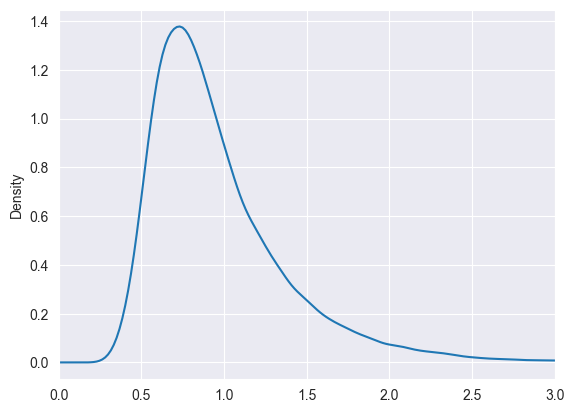

In [2]:
df["Seeing"].plot.kde(xlim=(0, 3))

* Question 1: what's the relation between the calibrated seeing during the photometric pipeline (FWHM), and the DIMM-measured seeing?
* Question 2: how close are TNG and ING seeing measurements?
* Question 3: how can the seeing be predicted from weather data?

## Getting data from LT headers

In [5]:
from aspred.connector import query_from_lt_header
import aspred.utils
import datetime

# Initial date

initial_date_mjd = aspred.utils.datetime_to_mjd(initial_date)
final_date_mjd = aspred.utils.datetime_to_mjd(final_date)

query = """SELECT mjd, AGFWHM, L1SEESEC FROM allkeys WHERE INSTRUME = "IO:O" AND AGFWHM != 0 AND mjd > """ + str(initial_date_mjd) + " AND mjd < " + str(final_date_mjd) + " ORDER BY mjd ASC"
df2 = query_from_lt_header(query)
df2["date"] = df2["mjd"].apply(aspred.utils.mjd_to_datetime)

print(len(df2), "rows")

15899 rows


/Users/fabarzuza/Documents/GitHub/aspred/aspred/connector.py:162: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframe = pd.read_sql(query, mydb)


In [4]:
df2

mjd  AGFWHM   L1SEESEC                       date
0      60310.005234   2.063    1.37555 2024-01-01 00:07:32.217600
1      60310.005756   2.063    1.13058 2024-01-01 00:08:17.318400
2      60310.006292   2.063    1.51499 2024-01-01 00:09:03.628800
3      60310.007329   2.063    1.45452 2024-01-01 00:10:33.225600
4      60310.007816   2.063    1.22453 2024-01-01 00:11:15.302400
...             ...     ...        ...                        ...
15894  60424.234737   2.694  999.00000 2024-04-24 05:38:01.276800
15895  60424.240471   2.694  999.00000 2024-04-24 05:46:16.694400
15896  60424.240801   2.694  999.00000 2024-04-24 05:46:45.206400
15897  60424.241203   2.694  999.00000 2024-04-24 05:47:19.939200
15898  60424.241533   2.694  999.00000 2024-04-24 05:47:48.451200

[15899 rows x 4 columns]

In [6]:
# Remove outliers with FWHM > 2
limit = 6
df2 = df2[df2["L1SEESEC"] < limit]
df = df[df["Seeing"] < limit]

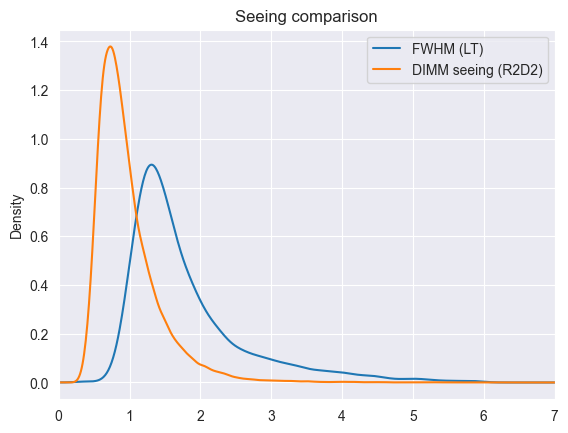

In [7]:
import matplotlib.pyplot as plt
df2["L1SEESEC"].plot.kde(xlim=(0, limit+1), label="FWHM (LT)")
df["Seeing"].plot.kde(xlim=(0, limit+1), label="DIMM seeing (R2D2)")
plt.title("Seeing comparison")
plt.legend()

In [8]:
# Creates a dataframe with 10 minute intervals from the initial date to the last date
date_range = pd.date_range(start=initial_date, end=final_date, freq="10min")

In [9]:
r2d2_list = []
fwhm_list = []
date_list = []

# Loop through the date range and calculate the average seeing (R2D2 and FWHM) for each interval
for i, date in enumerate(date_range):
    print(i, "out of ", len(date_range), end="\r")
    # Add exception for last date
    if i == len(date_range) - 1:
        continue
    # Find r2d2 seeing between this date and the next one
    r2d2_seeing = df[(df["Date"] >= date) & (df["Date"] < date_range[i+1])]["Seeing"]
    # Calculate average seeing for that interval
    r2d2_seeing_mean = r2d2_seeing.mean()
    # Find FWHM between this date and the next one
    fwhm = df2[(df2["date"] >= date) & (df2["date"] < date_range[i+1])]["L1SEESEC"]
    # Calculate average FWHM for that interval
    fwhm_mean = fwhm.mean()
    # Append to the lists
    r2d2_list.append(r2d2_seeing_mean)
    fwhm_list.append(fwhm_mean)
    date_list.append(date)
    

In [10]:
# Create dataframe with lists
df3 = pd.DataFrame({"date": date_list, "r2d2_seeing": r2d2_list, "fwhm_seeing": fwhm_list})
# Remove any rows that contains NaN in either column
df3 = df3.dropna()

Text(0.5, 1.0, 'Seeing comparison')

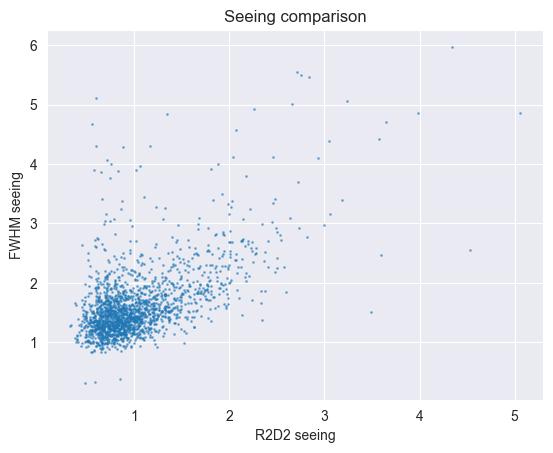

In [11]:
#Plot r2d2 seeing vs FWHM seeing
plt.scatter(df3["r2d2_seeing"], df3["fwhm_seeing"], alpha=0.5, s=1)
plt.xlabel("R2D2 seeing")
plt.ylabel("FWHM seeing")
plt.title("Seeing comparison")

In [12]:
# Find and assess correlation and linear fit
import numpy as np
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df3["r2d2_seeing"], df3["fwhm_seeing"])
print("Slope:", slope)
print("Intercept:", intercept)
print("R value:", r_value)
print("P value:", p_value)
print("Standard error:", std_err)




Slope: 0.7197119823543648
Intercept: 0.8901236642458032
R value: 0.5828441320474368
P value: 4.899290767721779e-172
Standard error: 0.023117140329391647


Text(0.5, 1.0, 'Seeing comparison')

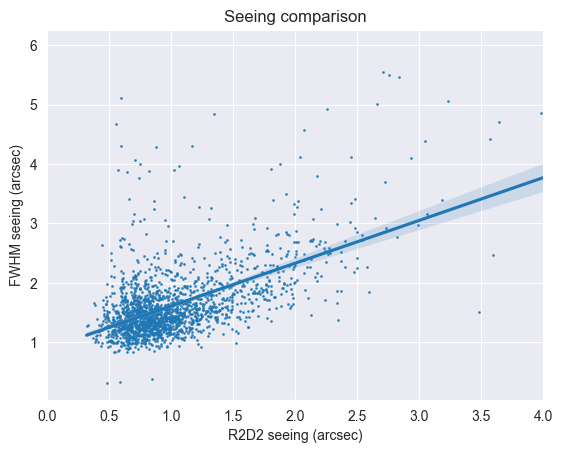

In [13]:
# Plot r2d2 seeing vs FWHM seeing with correlation line
import seaborn as sns
sns.regplot(x="r2d2_seeing", y="fwhm_seeing", data=df3, scatter_kws={"s": 1})
plt.xlim(0,4)
plt.xlabel("R2D2 seeing (arcsec)")
plt.ylabel("FWHM seeing (arcsec)")
plt.title("Seeing comparison")

Conclusion: there is no relation between the seeing measured by the DIMM sensor and the seeing measured by the FWHM in the images.


# Predicting seeing

In [17]:
#Fetch NRT data from InfluxDB
from influxdb_client import InfluxDBClient
import pandas as pd
host = 'https://influxdb.services.newrobotictelescope.org'
username = "nrt-admin"
password = "super_secret_password"
ssl = True
verify_ssl = True
token = "YNZ0oOiejxQT62BXkLyuQfTvH8su0ki9oMbv12l3VU7kwpUvk8NE_SSp10geFA6vKFg8TQMAd8y82tK2UtCVSg=="
org = "NRT"
bucket = "Weatherstation"

client = InfluxDBClient(host, token, org, timeout = 60000)
print('alive: %s' % client.ping())


query = """from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-28T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  """

query2 = """from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-28T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

mean_table = |> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
stddev_table = |> filter(fn: (r) => r["_field"] == "wind_speed_avg")
|> aggregateWindow(every: 30m, fn: stddev, createEmpty: false)
|> map(fn: (r) => ({ _time: r._time, _field: "wind_speed_avg_stddev", _value: r._value }))

join(tables: {mean: mean_table, stddev: stddev_table}, on: ["_time"])
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")"""

query3 = """
mean_table = from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-28T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

stddev_table = from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-28T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "wind_speed_avg")
|> aggregateWindow(every: 30m, fn: stddev, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

join(tables: {mean: mean_table, stddev: stddev_table}, on: ["_time"])
|> drop(columns: ["_start", "_stop"])
"""
system_stats = client.query_api().query_data_frame(query3, org)


>>> Request: 'GET https://influxdb.services.newrobotictelescope.org/ping?'
>>> Authorization: ***
>>> User-Agent: influxdb-client-python/1.43.0
>>> Content-Type: application/json
>>> Body: None
<<< Response: 204
<<< X-Influxdb-Build: OSS
<<< X-Influxdb-Version: v2.3.0+SNAPSHOT.090f681737
<<< Date: Tue, 02 Jul 2024 09:14:35 GMT
<<< Via: 1.1 google
<<< Alt-Svc: h3=":443"; ma=2592000,h3-29=":443"; ma=2592000
<<< Body: 
alive: True
>>> Request: 'POST https://influxdb.services.newrobotictelescope.org/api/v2/query?org=NRT'
>>> Accept: application/json
>>> Content-Type: application/json
>>> Authorization: ***
>>> User-Agent: influxdb-client-python/1.43.0
>>> Body: {'extern': {'imports': [], 'body': []}, 'query': '\nmean_table = from(bucket: "Weatherstation")\n|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-28T00:00:00Z)\n|> filter(fn: (r) => r["_measurement"] == "weatherstation")\n|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "rel

In [18]:
weather_data = system_stats[["_time", "air_pressure", "air_temperature", "relative_humidity", "wind_direction_avg", "wind_speed_avg_mean", "wind_speed_max", "wind_speed_avg_stddev"]]
weather_data["time"] = weather_data["_time"].dt.tz_localize(None)


/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_59382/987057805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data["time"] = weather_data["_time"].dt.tz_localize(None)


In [19]:
weather_data

_time  air_pressure  air_temperature  \
0    2024-02-07 09:00:00+00:00    778.300000         7.200000   
1    2024-02-07 09:30:00+00:00    778.372414         8.548276   
2    2024-02-07 10:00:00+00:00    778.580000         9.288000   
3    2024-02-07 10:30:00+00:00    778.580000         9.136667   
4    2024-02-07 11:00:00+00:00    778.641379         9.541379   
...                        ...           ...              ...   
6789 2024-06-27 22:00:00+00:00    775.027586        10.013793   
6790 2024-06-27 22:30:00+00:00    775.053333         9.780000   
6791 2024-06-27 23:00:00+00:00    775.131034         9.693103   
6792 2024-06-27 23:30:00+00:00    775.253333        10.140000   
6793 2024-06-28 00:00:00+00:00    775.303448        10.613793   

      relative_humidity  wind_direction_avg  wind_speed_avg_mean  \
0              8.400000          192.000000             3.000000   
1              5.127586          180.068966             3.906897   
2              5.044000          166.480000             2.744000   
3              7.533333          155.600000             3.110000   
4              9.865517          151.034483             2.720690   
...                 ...                 ...                  ...   
6789          28.531034           33.862069             3.234483   
6790          27.323333           41.633333             4.043333   
6791          22.813793           39.137931             3.727586   
6792          40.330000           41.966667             4.923333   
6793          46.724138           49.724138             3.179310   

      wind_speed_max  wind_speed_avg_stddev                time  
0           4.200000                    NaN 2024-02-07 09:00:00  
1           5.048276               0.780078 2024-02-07 09:30:00  
2           3.404000               0.501730 2024-02-07 10:00:00  
3           4.313333               0.562231 2024-02-07 10:30:00  
4           3.568966               0.581488 2024-02-07 11:00:00  
...              ...                    ...                 ...  
6789        6.300000               0.749417 2024-06-27 22:00:00  
6790        7.556667               0.801156 2024-06-27 22:30:00  
6791        6.868966               1.114802 2024-06-27 23:00:00  
6792        7.546667               0.684147 2024-06-27 23:30:00  
6793        5.548276               0.770148 2024-06-28 00:00:00  

[6794 rows x 9 columns]

In [21]:
from aspred.connector import r2d2_seeing
from datetime import datetime
initial_date = datetime(2024, 2, 7)
final_date = datetime(2024, 6, 28)
df = r2d2_seeing(initial_date, final_date)

Fetching data from https://astro.ing.iac.es/seeing/r2d2_data.php?date1=2024-02-07&date2=2024-06-28&submit=Submit...
Data retrieved successfully


In [22]:
df

Date  Seeing
0     2024-02-07 00:00:05  0.6346
1     2024-02-07 00:01:03  0.7416
2     2024-02-07 00:02:01  0.6790
3     2024-02-07 00:02:04  0.7846
4     2024-02-07 00:03:02  0.7514
...                   ...     ...
46506 2024-06-27 22:56:00  0.7340
46507 2024-06-27 22:56:03  0.5822
46508 2024-06-27 22:58:03  0.6943
46509 2024-06-27 22:59:01  0.7402
46510 2024-06-27 22:59:04  0.7511

[46511 rows x 2 columns]

In [23]:
# Add seeing into weather_data, calculating average for time intervals
import numpy as np

seeing_list = []
date_list = []
for i, date in enumerate(weather_data["time"]):
    print(i, "out of ", len(weather_data["_time"]), end="\r")
    if i == len(weather_data["_time"]) - 1:
        continue
    seeing = df[(df["Date"] >= date) & (df["Date"] < weather_data["time"][i+1])]["Seeing"]
    seeing_mean = seeing.mean()
    seeing_list.append(seeing_mean)
    date_list.append(date)
seeing_list

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.50385,
 0.96414,
 0.9987239999999998,
 1.049947368421053,
 1.0420210526315785,
 0.8252434782608696,
 0.9360690476190475,
 1.099463157894737,
 0.8916,
 1.15,
 0.89465,
 2.1149,
 1.2294999999999998,
 nan,
 nan,
 nan,
 nan,
 1.1907,
 1.6237,
 1.2743,
 2.3352,
 nan,
 1.4272,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8687,
 0.9559340425531915,
 0.9504294117647059,
 0.9564749999999999,
 1.0709666666666666,
 0.882525,
 nan,
 1.6705,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,


In [24]:
# Remove last row from weather dataframe and add seeing
weather_data = weather_data[:-1]
weather_data["seeing"] = seeing_list

clean_weather_data = weather_data.dropna()

/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_59382/2743535150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data["seeing"] = seeing_list


In [25]:
clean_weather_data

_time  air_pressure  air_temperature  \
19   2024-02-07 18:30:00+00:00    776.355172        11.365517   
20   2024-02-07 19:00:00+00:00    776.196667        10.173333   
21   2024-02-07 19:30:00+00:00    776.392857         9.857143   
22   2024-02-07 20:00:00+00:00    776.533333         8.886667   
23   2024-02-07 20:30:00+00:00    776.727586         9.486207   
...                        ...           ...              ...   
6786 2024-06-27 20:30:00+00:00    774.800000        10.975862   
6787 2024-06-27 21:00:00+00:00    774.863333        10.550000   
6788 2024-06-27 21:30:00+00:00    774.917241        10.258621   
6789 2024-06-27 22:00:00+00:00    775.027586        10.013793   
6790 2024-06-27 22:30:00+00:00    775.053333         9.780000   

      relative_humidity  wind_direction_avg  wind_speed_avg_mean  \
19            12.534483          212.517241             1.493103   
20             9.230000          201.466667             1.493333   
21             6.667857          212.357143             1.692857   
22            10.860000          164.800000             2.223333   
23             6.886207          226.827586             1.527586   
...                 ...                 ...                  ...   
6786          14.286207           22.965517             3.162069   
6787          22.323333           30.133333             3.823333   
6788          29.358621           32.551724             3.855172   
6789          28.531034           33.862069             3.234483   
6790          27.323333           41.633333             4.043333   

      wind_speed_max  wind_speed_avg_stddev                time    seeing  
19          2.493103               0.620444 2024-02-07 18:30:00  0.503850  
20          2.113333               0.556425 2024-02-07 19:00:00  0.964140  
21          2.400000               0.504005 2024-02-07 19:30:00  0.998724  
22          2.760000               0.542461 2024-02-07 20:00:00  1.049947  
23          2.386207               0.483216 2024-02-07 20:30:00  1.042021  
...              ...                    ...                 ...       ...  
6786        6.127586               0.683172 2024-06-27 20:30:00  0.848569  
6787        7.153333               0.949295 2024-06-27 21:00:00  0.931200  
6788        7.227586               0.696720 2024-06-27 21:30:00  0.864810  
6789        6.300000               0.749417 2024-06-27 22:00:00  0.729804  
6790        7.556667               0.801156 2024-06-27 22:30:00  0.722379  

[1677 rows x 10 columns]

# Unsuperised learning

In [26]:
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = clean_weather_data.drop(columns=['seeing', '_time', 'time'])
y = clean_weather_data['seeing']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a new dataframe with the PCA results
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['seeing'] = y.values


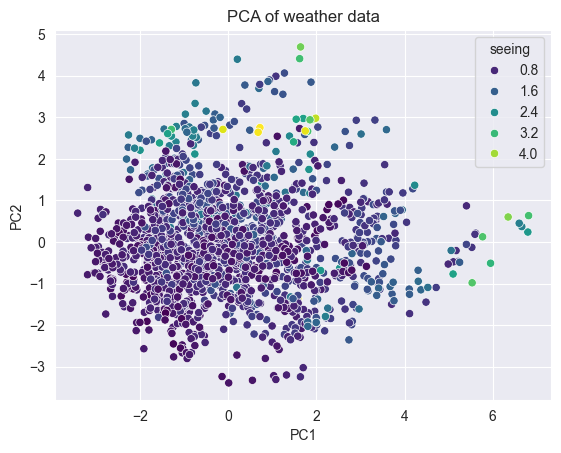

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='seeing', palette='viridis')
plt.title('PCA of weather data')
plt.show()


In [29]:
from sklearn.cluster import KMeans

# Choose the number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_pca['Cluster'] = clusters


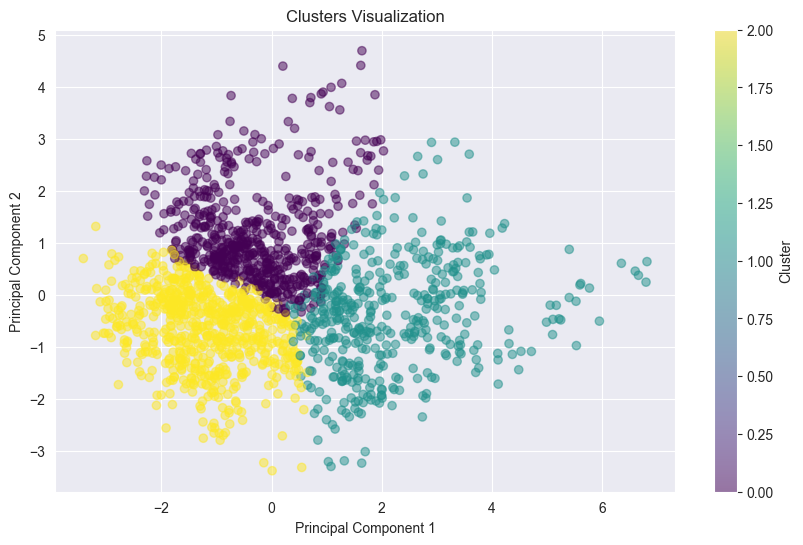

Cluster 2:
count    673.000000
mean       0.781604
std        0.208558
min        0.334666
25%        0.635763
50%        0.743903
75%        0.889096
max        2.030556
Name: seeing, dtype: float64


Cluster 0:
count    561.000000
mean       1.227871
std        0.594700
min        0.452130
25%        0.823656
50%        1.100597
75%        1.436335
max        4.584267
Name: seeing, dtype: float64


Cluster 1:
count    443.000000
mean       1.063047
std        0.488147
min        0.375253
25%        0.776371
50%        0.955060
75%        1.219956
max        4.484700
Name: seeing, dtype: float64




In [30]:
import matplotlib.pyplot as plt

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Analyze the distribution of "seeing" in each cluster
for cluster in df_pca['Cluster'].unique():
    cluster_data = df_pca[df_pca['Cluster'] == cluster]
    print(f'Cluster {cluster}:')
    print(cluster_data['seeing'].describe())
    print('\n')


# Supervised learning

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 0.06300427441283303
R2 Score: 0.6958332493574695


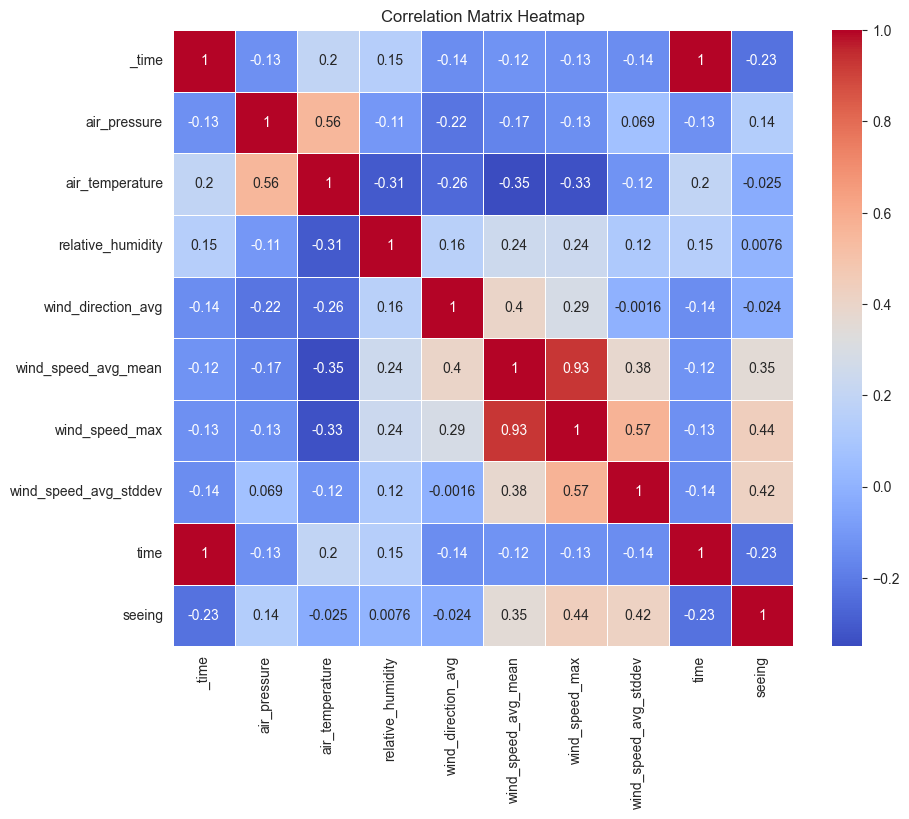

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = clean_weather_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


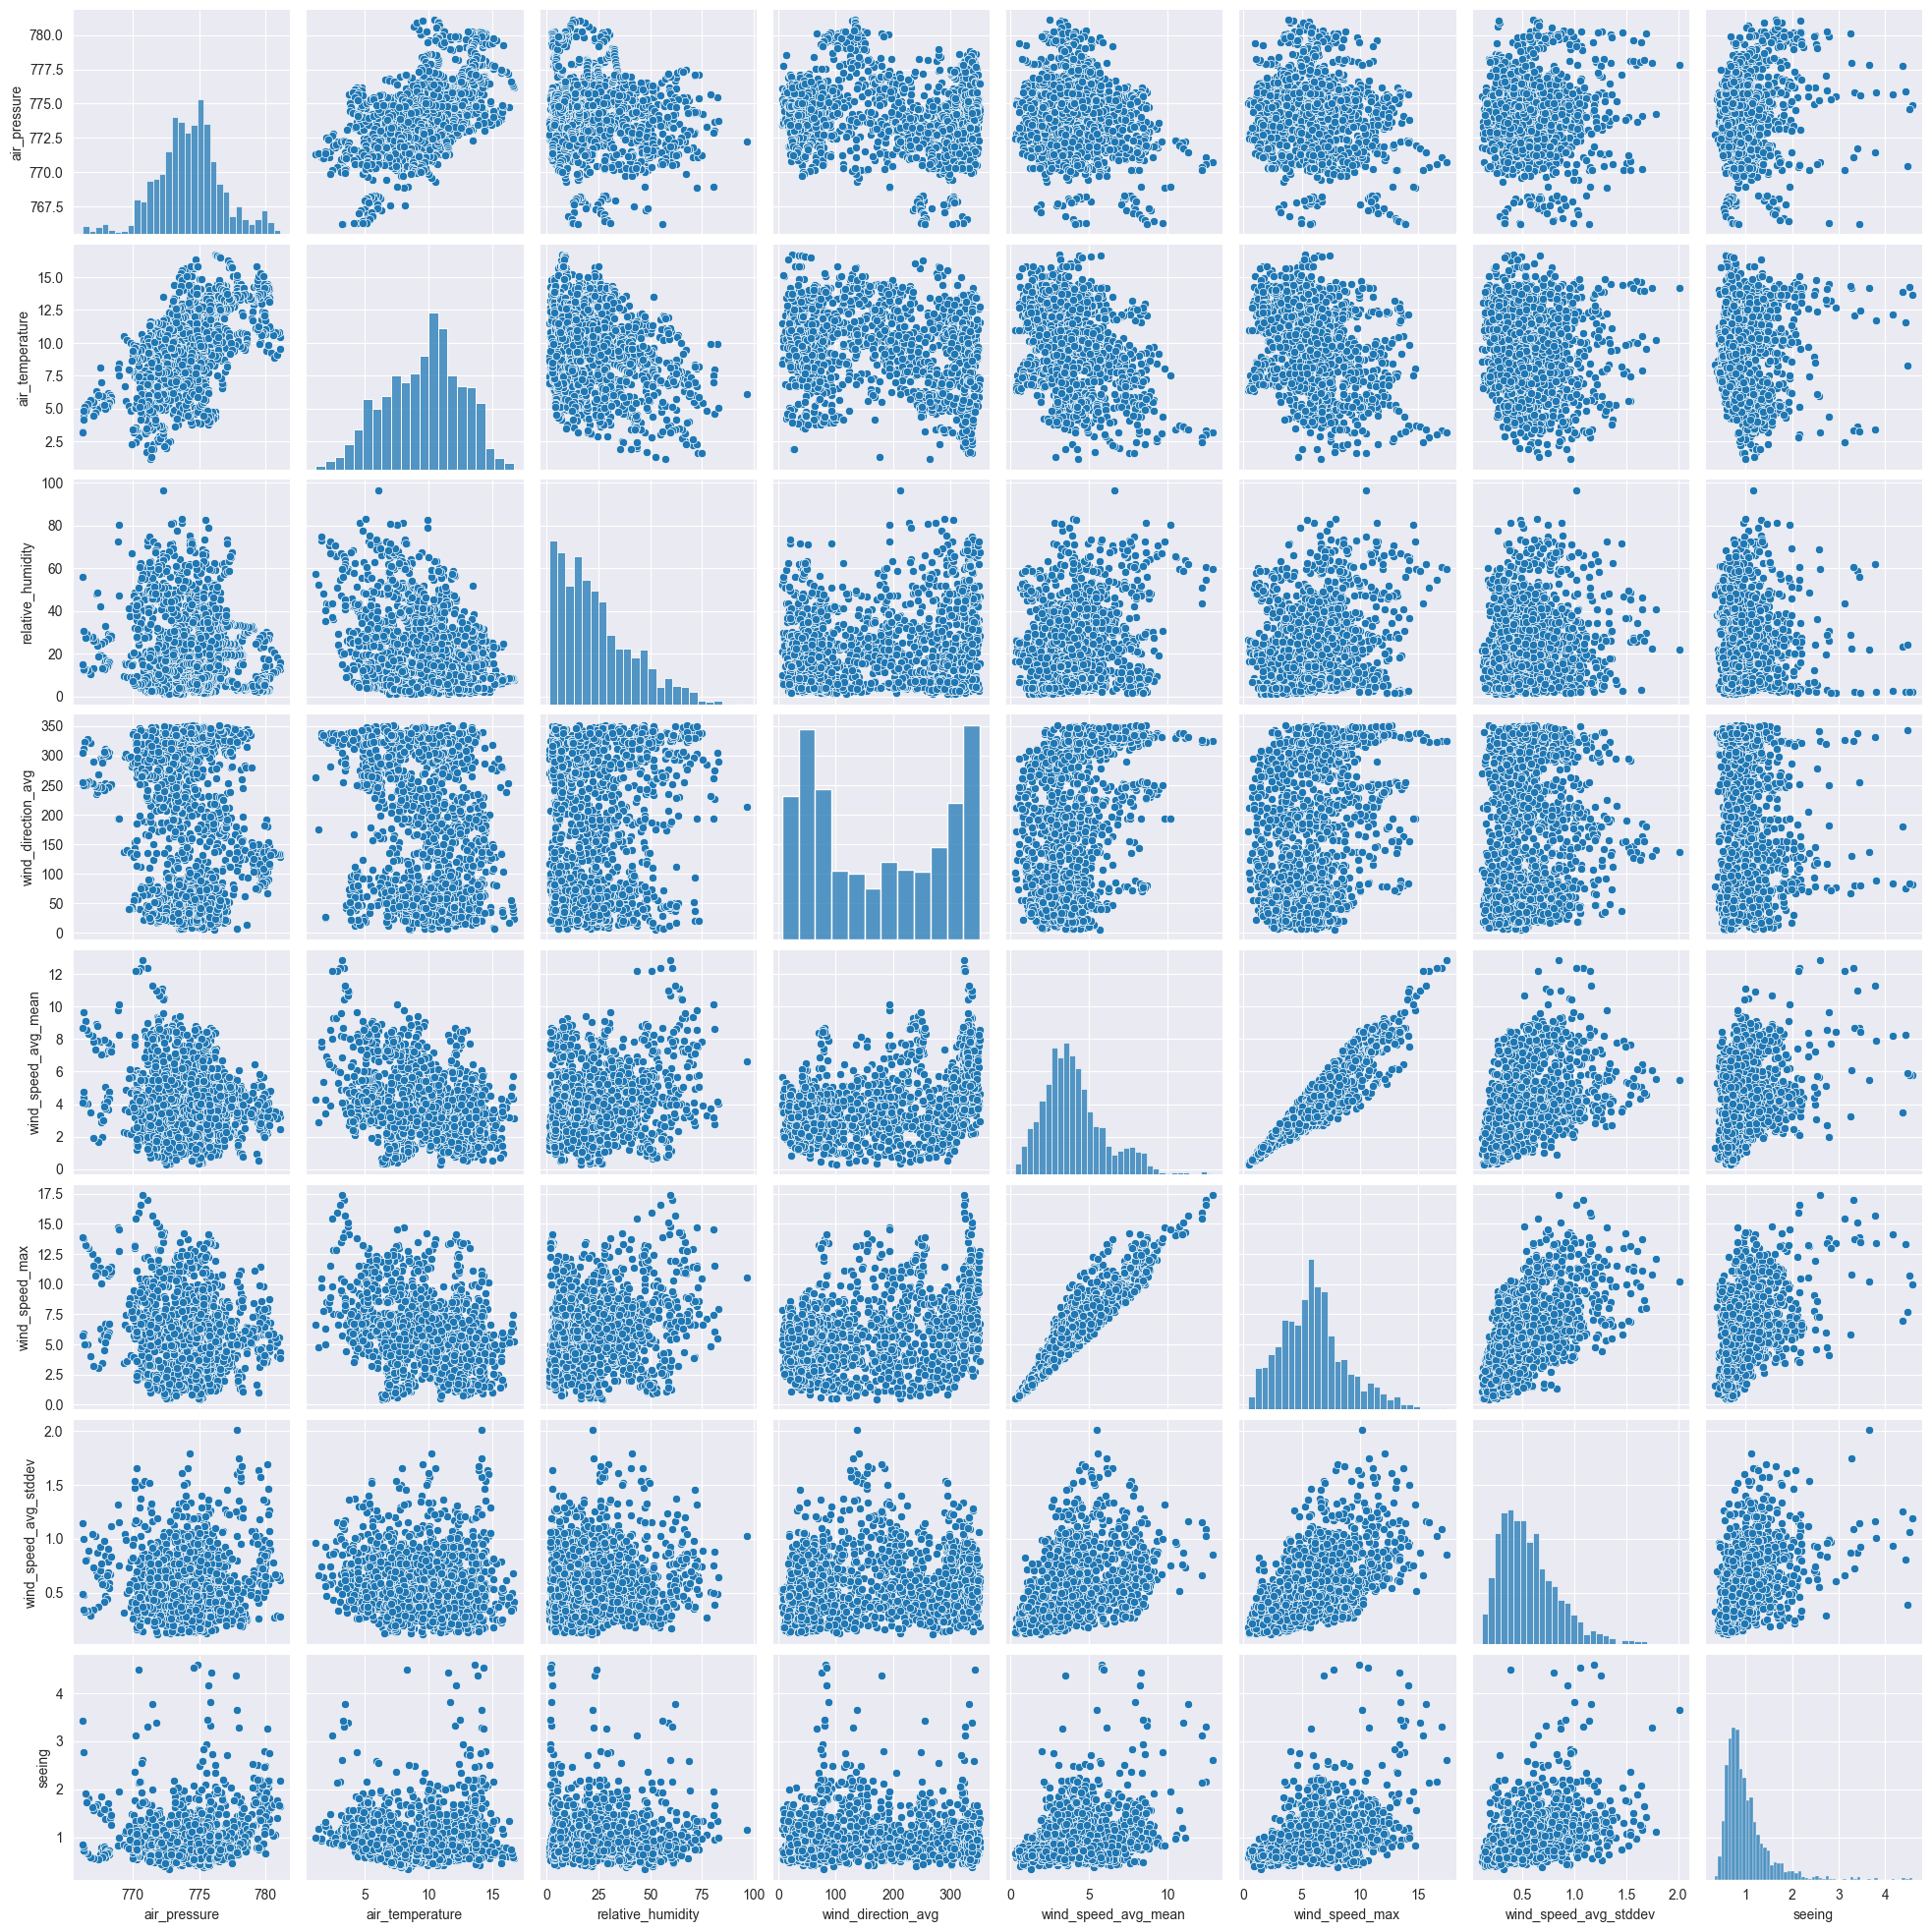

In [35]:
sns.pairplot(clean_weather_data)
plt.show()

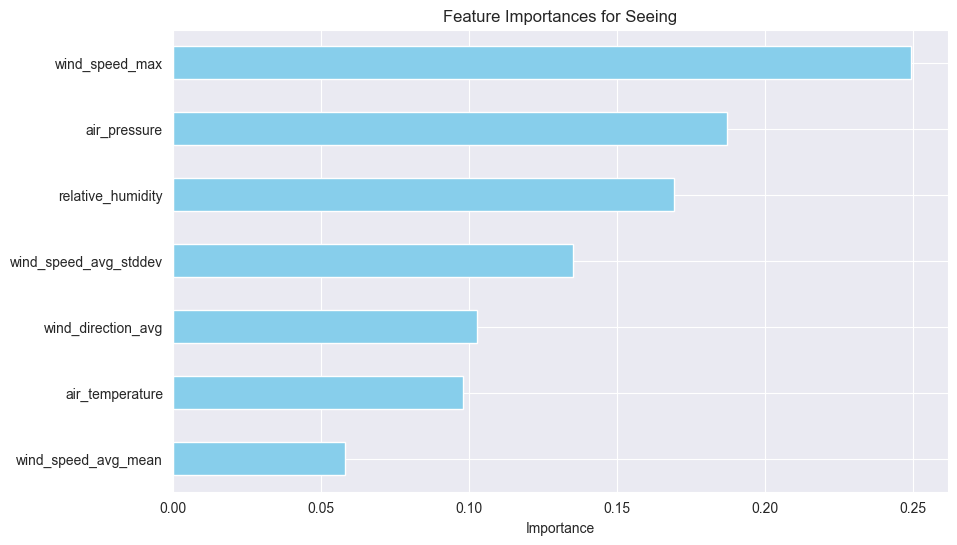

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# Sort and plot feature importances
sorted_importances = feature_importances.sort_values()
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importances for Seeing')
plt.xlabel('Importance')
plt.show()



In [37]:
# Create a new column with the predicted seeing
clean_weather_data['seeing_predicted'] = model.predict(X_scaled)

/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_59382/2529860354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_weather_data['seeing_predicted'] = model.predict(X_scaled)


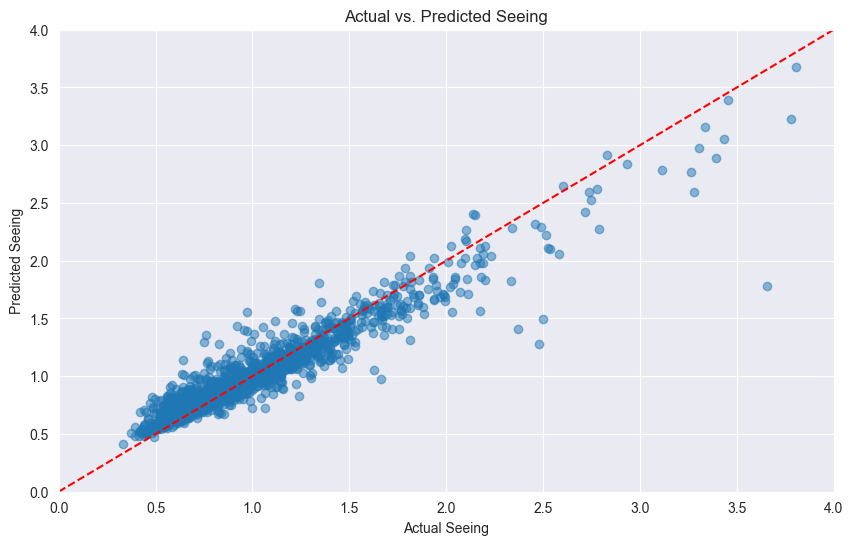

In [38]:
# Plot the actual vs. predicted seeing with linear regression, r squared, and p value
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.figure(figsize=(10, 6))
plt.scatter(clean_weather_data['seeing'], clean_weather_data['seeing_predicted'], alpha=0.5)
plt.plot([0, 4], [0, 4], color='red', linestyle='--')
plt.xlim(0, 4)
plt.ylim(0, 4)

plt.xlabel('Actual Seeing')
plt.ylabel('Predicted Seeing')
plt.title('Actual vs. Predicted Seeing')
plt.show()

In [39]:
# We print the r correlation and the p parameter
slope, intercept, r_value, p_value, std_err = linregress(clean_weather_data['seeing'], clean_weather_data['seeing_predicted'])
print("Slope:", slope)
print("Intercept:", intercept)
print("R value:", r_value)
print("P value:", p_value)
print("Standard error:", std_err)

Slope: 0.7884088771973538
Intercept: 0.21753239653030543
R value: 0.9558323998903157
P value: 0.0
Standard error: 0.005923522895089363


In [40]:
# Add the predicted seeing to the dataframe
clean_weather_data['seeing_predicted'] = model.predict(X_scaled)

/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_59382/2043567219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_weather_data['seeing_predicted'] = model.predict(X_scaled)


/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_59382/3317343495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_weather_data['seeing_difference'] = clean_weather_data['seeing'] - clean_weather_data['seeing_predicted']


Text(0, 0.5, 'Seeing Difference')

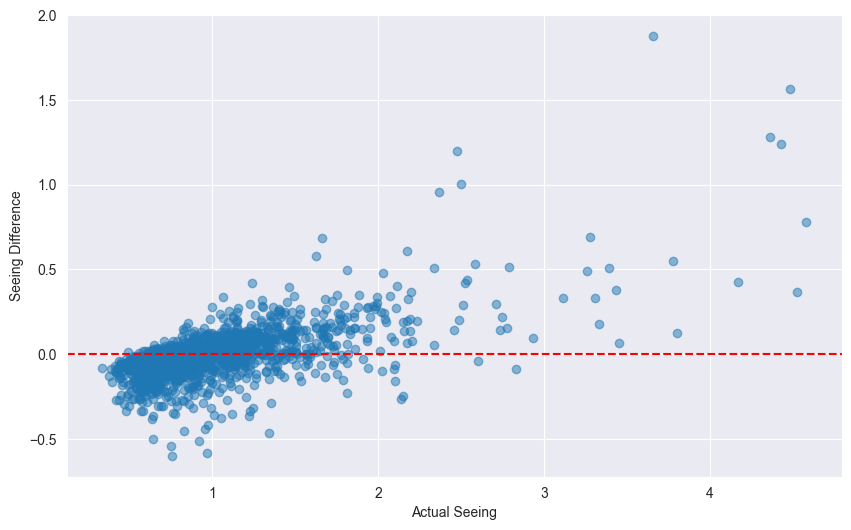

In [43]:
# Plot the difference between actual seeing and predicted seeing, in function of the actual seeing
clean_weather_data['seeing_difference'] = clean_weather_data['seeing'] - clean_weather_data['seeing_predicted']

plt.figure(figsize=(10, 6))
plt.scatter(clean_weather_data['seeing'], clean_weather_data['seeing_difference'], alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Seeing")
plt.ylabel("Seeing Difference")